# 1. Introduction

Forecasting weather is a difficult problem that is important to our daily lives. Here we will explore two smaller aspects of weather forecasting. Using ~10 years of weather station data from all over Australia, we will try to answer two questions:

1. How well can a relatively simple random forest classifier use common weather data (temperature, humidity, winds, air pressure, etc.) to predict if it will rain on the weather station **tomorrow**?
2. Even more simply: how well can a random forest classifier use the same data to predict if there was rainfall at the weather station the **same day**?

# 2. Imports and setup

In [69]:
# importing, reading, and combining data
import numpy as np 
import pandas as pd

# sklearn for classifiers and testing
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# data balancing
import collections
from imblearn.over_sampling import SMOTE

# figures and visualization
import matplotlib.ticker as mticker
import plotly.express as px
import seaborn as sn
import matplotlib.pyplot as plt

# misc
import time

# maps
import geopandas as gpd

In [70]:
# get source data
source_directory = "E:\Git_repos\Australian_rain/"
source_table = "E:\Git_repos\Australian_rain\weatherAUS.csv"
shapefile = "E:\Git_repos\Australian_rain\states\STE_2016_AUST.shp"
source_df = pd.read_csv(source_table)

# explore dataset
source_df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No


# 3. Raw data exploration

This dataset contains a lot of really cool weather data that's fun to play around with in its own right. 

## 3.1 Temperature and humidity

Let's examine some of the cyclical changes in temperature across Australia.

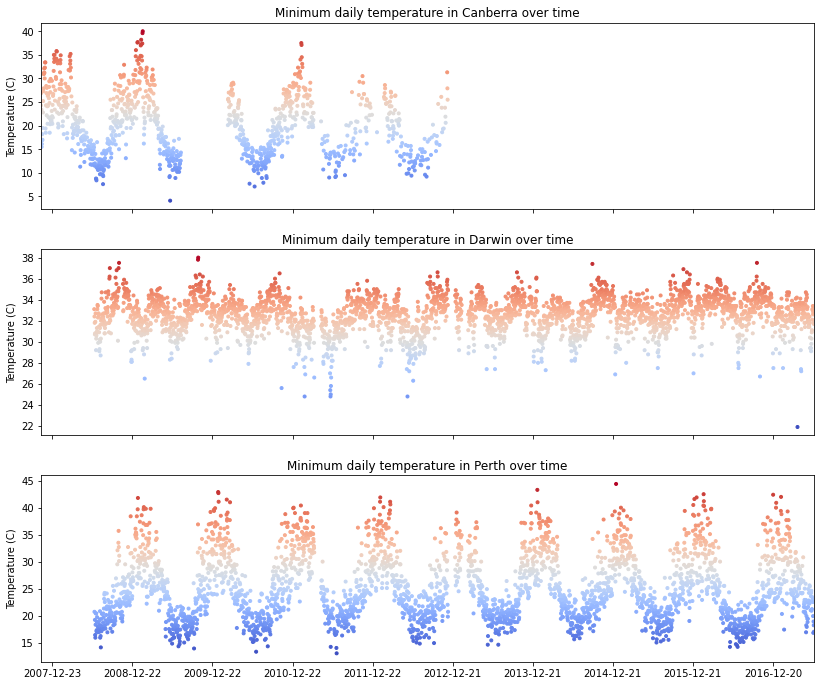

In [82]:
# set up time series figure
fig, ax = plt.subplots(3, figsize=(12, 10), sharex=True);

# add some padding
fig.tight_layout(pad=3.0)

# set a list of cities to examine
city_list = ["Canberra", "Darwin", "Perth"]

# get x axis range from the city list
city_df = source_df[source_df["Location"].isin(city_list)]
x_min = min(pd.to_datetime(city_df["Date"]))
x_max = max(pd.to_datetime(city_df["Date"]))


# make a function to generate some scatter plots
def plot_minimum_temperature(station, index):
    
    # mask out a station of interest
    station_id = station
    station = source_df[source_df["Location"] == station_id] 
    min_temp = station["MinTemp"]

    # plot the time series
    ax[index].scatter(pd.to_datetime(station["Date"]), min_temp, 
               c=station["MinTemp"], marker=".", 
               cmap="coolwarm");

    # set titles, labels; remove axes
    ax[index].set_title("Minimum daily temperature in {} over time".format(station_id))
    ax[index].set_ylabel("Temperature (C)")
    
    # set ticks to be every year (365 days)
    yearLocator = mticker.MultipleLocator(365)
    ax[index].xaxis.set_major_locator(yearLocator)
    
    # set the min and max limits to be the same on each subplot
    ax[index].set_xlim([x_min, x_max])
    
    # set the background to be white
    ax[index].set(facecolor="white")
    
# plot some station data
for city, index in zip(city_list, range(0, len(city_list)+1)):
    plot_minimum_temperature(city, index)
    
plt.savefig(source_directory + "/Figures/Example-temp_data.png", dpi=300, facecolor="white")

Note that the temperatures in Darwin (nearer to the equator) are much hotter in the summer and winter, and that the summers in Darwin are also much longer. Canberra has realtively cold winters, but the lengths of the seasons match Perth as they are near the same latitude.

## 3.2 Wind data

Since we have wind direction data it's only natural that we should make a rose diagram too!

In [72]:
# make out the station of interest
wind_df = source_df[source_df["Location"] == "Canberra"]

# get the wind directions as frequencies
wind_df = wind_df.groupby(["WindGustDir"]).size().reset_index(name="frequency")

# put the values in cardinal directions
cardinal_order = ["N", "NNE", "NE", "ENE", 
                  "E", "ESE", "SE", "SSE", 
                  "S", "SSW", "SW", "WSW", 
                  "W", "WNW", "NW", "NNW"]

# set the direction as the index
wind_df = wind_df.set_index(wind_df["WindGustDir"])

# reorder it based on the correct direction
wind_df = wind_df.reindex(cardinal_order)

# generate a rose diagram
fig = px.bar_polar(wind_df, r="frequency", theta="WindGustDir",
                   color="frequency", template="simple_white",
                   color_discrete_sequence= px.colors.sequential.haline)

# add a title and legend
fig.update_layout(
    title='Wind Speed Distribution in Canberra, Australia',
    font_size=12,
    legend_font_size=12,
    polar_angularaxis_rotation=90)
  
# show the figure
fig.show()

# save
plt.savefig(source_directory + "/Figures/Example-wind_data.png", dpi=300, facecolor="white")

<Figure size 432x288 with 0 Axes>

Seems to be have a very strong NW signal, and a smaller E component.

# 4. Data preparation

We need to massage our data for the algorithms, and also to enable later analysis. Here we'll assign each station to the state it's in, and change our categorical data with numerical substitutes. We also need to elimate records where NaN values cannot be determined, and fill NaN values where we can.

In [73]:
# make territory dictionary (ew manual work)
territory_dict = {"New South Wales": ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree', 
                          'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond', 
                          'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Wollongong'],
                  "Victoria": ['Ballarat', 'Bendigo', 'Dartmoor', 'Sale', 'MelbourneAirport', 'Melbourne','Mildura',
                          'Nhil', 'Portland', 'Watsonia'],
                  "Queensland": ['Brisbane', 'Cairns', 'GoldCoast', 'Townsville'],
                  "South Australia": ['Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera'],
                  "Western Australia": ['Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 'SalmonGums'
                          'Walpole'],
                  "Tasmania": ['Hobart', 'Launceston'],
                  "Northern Territories": ['AliceSprings', 'Darwin', 'Katherine', 'Uluru'],
                  "Australian Capital Territory": ['Canberra', 'Tuggeranong', 'Mount Ginini'], }

# replace categorical values
cardinal_dict = {"N": 0, "NNE": 1, "NE": 2, "ENE": 3,
                 "E": 4, "ESE": 5, "SE": 6, "SSE": 7,
                 "S": 8, "SSW": 9, "SW": 10, "WSW": 11,
                 "W": 12, "WNW": 13, "NW": 14, "NNW": 15}


# substitute the cardinal directions wherever they occur
categorical_replacements = {"WindGustDir": cardinal_dict,
                            "WindDir9am": cardinal_dict,
                            "WindDir3pm": cardinal_dict,
                            "RainToday": {"No":0, "Yes": 1},
                            "RainTomorrow": {"No":0, "Yes": 1}}

# convert the categorical data
source_df = source_df.replace(categorical_replacements)

# drop columns that are mostly NaN right away.
source_df.drop(columns=['Evaporation', 'Sunshine', "Cloud9am", "Cloud3pm"])

# drop any row with a NaN
source_df = source_df.dropna(axis=0)

# check the header now
source_df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,9.0,48.0,3.0,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0.0,0.0
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,8.0,37.0,7.0,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0.0,0.0
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,1.0,46.0,1.0,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0.0,0.0
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,13.0,31.0,13.0,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0.0,0.0
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,13.0,35.0,14.0,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0.0,0.0
6055,2009-01-07,Cobar,27.1,36.1,0.0,13.0,0.0,0.0,43.0,0.0,...,26.0,19.0,1007.7,1007.4,8.0,8.0,30.7,34.3,0.0,0.0
6056,2009-01-08,Cobar,23.3,34.0,0.0,9.8,12.6,9.0,41.0,8.0,...,33.0,15.0,1011.3,1009.9,3.0,1.0,25.0,31.5,0.0,0.0
6057,2009-01-09,Cobar,16.1,34.2,0.0,14.6,13.2,6.0,37.0,6.0,...,25.0,9.0,1013.3,1009.2,1.0,1.0,20.7,32.8,0.0,0.0
6058,2009-01-10,Cobar,19.0,35.5,0.0,12.0,12.3,3.0,48.0,3.0,...,46.0,28.0,1008.3,1004.0,1.0,5.0,23.4,33.3,0.0,0.0
6059,2009-01-11,Cobar,19.7,35.5,0.0,11.0,12.7,2.0,41.0,1.0,...,61.0,14.0,1007.9,1005.8,1.0,5.0,24.0,33.6,0.0,0.0


## 4.1 Checking for correlated values

Since we're going to be training some models on these data, we should make sure that we don't have any proxy features that will let the model cheat. Here we'll generate a correlation matrix between all the features. We're most concerned about high correlations between "Rainfall" (measured in mm), "RainToday" (binary yes/no or really 1/0), and "RainTomorrow" (also binary 1/0).

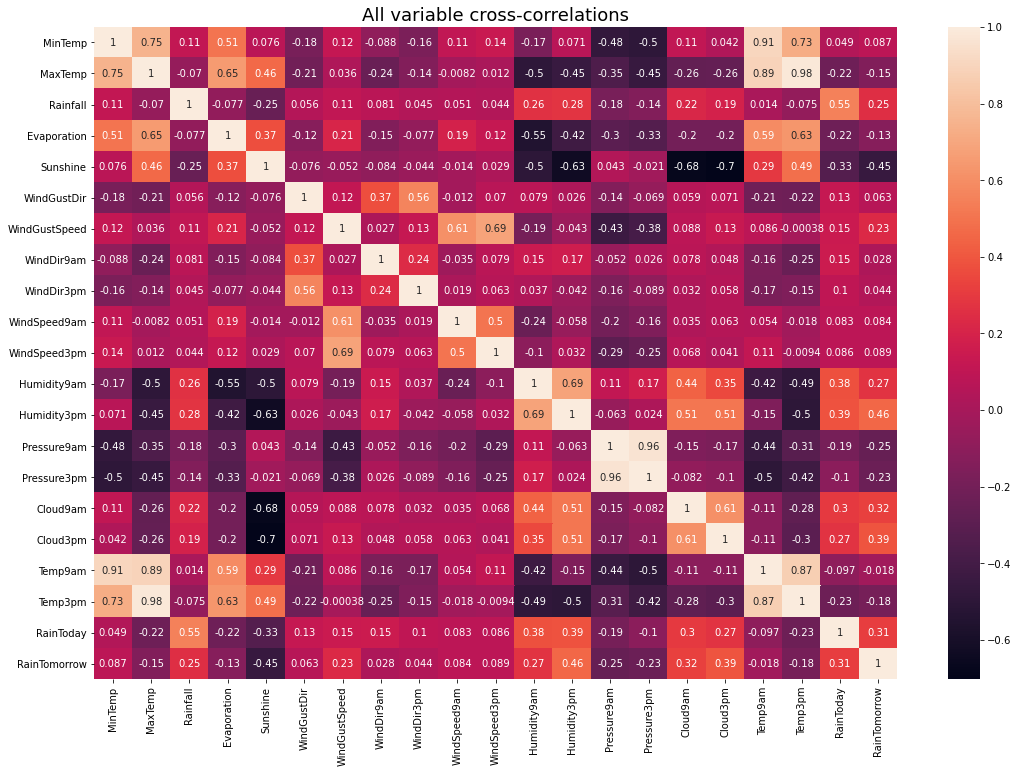

In [74]:
# set up the correlation figure
fig, ax = plt.subplots(1, figsize=(18, 12));

correlation_df = source_df

ax.set_title("All variable cross-correlations", fontdict={"fontsize": "18", "fontweight": "3"}, 
             loc='center', pad=None)

corrMatrix = correlation_df.corr()
sn.heatmap(corrMatrix, annot=True ,ax=ax)
plt.show()

"Rainfall" and "RainToday" are correlated (0.5) which is no suprise. We will exlude "Rainfall" when we try to predict "RainToday". Otherwise, the correlations between the other features and and "RainToday" and "RainTomorrow" are very low, which is excellent. This will allow us to demonstrate the efficacy of a complex model like a random forest. 

Next, we'll set up the features and targets for predicting rain tomorrow.

In [75]:
# get a list of features, split into independent and dependent
tomorrow_feature_list = ['MinTemp', 'MaxTemp', 
                         'Rainfall', 'WindGustDir', 
                         'WindGustSpeed', 'WindDir9am', 
                         'WindDir3pm', 'WindSpeed9am', 
                         'WindSpeed3pm', 'Humidity9am', 
                         'Humidity3pm', 'Pressure9am', 
                         'Pressure3pm', 'Temp9am', 
                         'Temp3pm', 'RainToday']
tomorrow_target_list = ['RainTomorrow']

# split
features = source_df.loc[:, tomorrow_feature_list]
target = source_df.loc[:, tomorrow_target_list]

## 4.2 Balancing the classes

Rain in Australia is pretty rare, so let's check to see if our "RainTomorrow" classes are imbalanced.

In [76]:
# check the balance of the data
count_no_rain = len(target[target["RainTomorrow"] == 0])
count_rain = len(target[target["RainTomorrow"] == 1])
balance = round(count_rain/count_no_rain, 1)
print("The starting balance is: ~{}% 'rain'.".format(100*balance))

The starting balance is: ~30.0% 'rain'.


Let's plot some data and see which values correspond to rain.

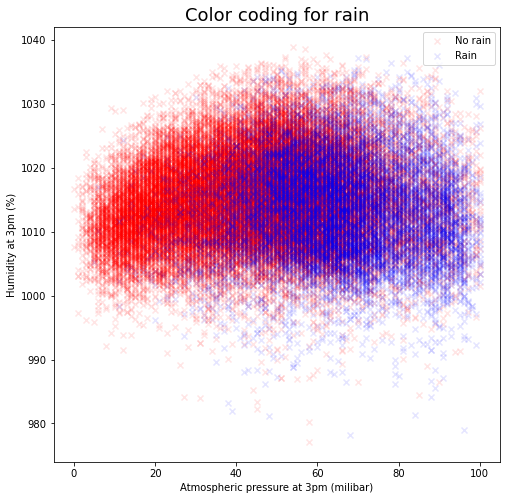

In [77]:
# set up a figure
fig, ax = plt.subplots(1, figsize=(8, 8));

# set the title
ax.set_title("Color coding for rain", fontdict={"fontsize": "18", "fontweight": "3"}, 
             loc='center', pad=None)

# plot two variables and color code by our target classes
ax.scatter(source_df.loc[source_df['RainToday'] == 0, 'Humidity3pm'], 
           source_df.loc[source_df['RainToday'] == 0, 'Pressure3pm'], 
           c='red', alpha=0.1, marker='x', label='No rain')

ax.scatter(source_df.loc[source_df['RainToday'] == 1, 'Humidity3pm'], 
           source_df.loc[source_df['RainToday'] == 1, 'Pressure3pm'], 
           c='blue', alpha=0.1, marker='x', label='Rain')

# label the axes
ax.set_ylabel("Humidity at 3pm (%)")
ax.set_xlabel("Atmospheric pressure at 3pm (milibar)")

plt.legend()
plt.show()

There are way more red values than green values so our data are imbalanced. We can fix that by generating sythetic samples of "rain" in "RainTomorrow" to even things out.

In [78]:
# balance the data via SMOTE
oversample = SMOTE()
features_res, target_res = oversample.fit_resample(features, target)

Now let's compare that same plot.

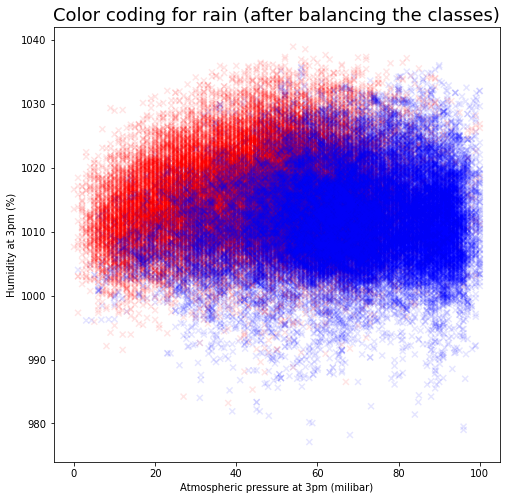

In [79]:
# set up a figure
fig, ax = plt.subplots(1, figsize=(8, 8));

# set the title
ax.set_title("Color coding for rain (after balancing the classes)", fontdict={"fontsize": "18", "fontweight": "3"}, 
             loc='center', pad=None)

# plot two variables and color code by our target classes
ax.scatter(features_res["Humidity3pm"], features_res["Pressure3pm"], 
            c=target_res["RainTomorrow"], alpha=0.1, marker='x', cmap='bwr_r')

# label the axes
ax.set_ylabel("Humidity at 3pm (%)")
ax.set_xlabel("Atmospheric pressure at 3pm (milibar)")

plt.show()

The target classes are much more balanced now.

## 4.3 We next need to scale all the features for the model.

In [80]:
# standardize all the features
features = StandardScaler().fit_transform(features)

## 4.4 Reserving data for model evaluation 

We'll reserve 20% of the data as our test sample.

In [81]:
# train test split 80/20%
feature_train, feature_test, target_train, target_test = train_test_split(features_res, 
                                                                          target_res, 
                                                                          test_size=0.2, 
                                                                          random_state=42)

# 5. Developing a model pipline

## 5.1 Hyperparameter optimization

To optimize our models we'll do a cross-validated grid search. To make things easier, we'll make a function to return the optimal values.

In [15]:
# define a function that performs a grid search
def rain_grid_search(estimator, parameter_grid, train_X, train_y):
  
    # mark the start of the tuning process  
    start_time = time.time()

    # initalize the grid search, use all available processors
    grid_search = GridSearchCV(estimator, parameter_grid, n_jobs=-1)

    # apply the grid search to the training data
    grid_search_application = grid_search.fit(train_X, train_y.values.ravel())

    # mark the end of the tuning process
    end_time = time.time()

    # print the elapsed time
    print("Grid search time: {}s".format(round(end_time - start_time, 3)))

    # return the best parameters
    return(grid_search_application.best_params_)

## 5.2 Fitting a model and returning results 

Next, we'll write a function to apply our classifier and return the results we want in a nice format.

In [46]:
# write a function to apply the classier
def apply_random_forest(train_X, train_y, test_X, test_y, parameters):
    
    # mark the start time
    start_time = time.time()

    # initialize the model
    rf_model = RandomForestClassifier(n_estimators = parameters['n_estimators'],
                                      criterion = parameters['criterion'],
                                      max_depth = parameters['max_depth'],
                                      min_samples_leaf = parameters['min_samples_leaf'],
                                      max_features = parameters['max_features'])

    # handle pandas dataframes, arrays work natively
    if isinstance(train_y, pd.DataFrame):
        train_y = train_y.values.ravel()

    # fit the model to the training data
    rf_model.fit(train_X, train_y)

    # apply the model to the test data
    rf_model_predict = rf_model.predict(test_X)

    # mark the end time
    end_time = time.time()

    # save the time elapsed
    rf_model_time = round(end_time - start_time, 3)

    # get the results as a dictionary
    rf_dict_results = classification_report(test_y, rf_model_predict, output_dict=True)
    
    # set up the class
    class results:
          def __init__(self, 
                       rain_precision, 
                       rain_recall, 
                       rain_f1, 
                       no_rain_precision, 
                       no_rain_recall, 
                       no_rain_f1, 
                       accuracy):
            self.rain_precision = rain_precision
            self.rain_recall = rain_recall
            self.rain_f1 = rain_f1
            self.no_rain_precision = no_rain_precision
            self.no_rain_recall = no_rain_recall
            self.no_rain_f1 = no_rain_f1
            self.accuracy = accuracy

    # print the processing time  
    print("Time to apply the classifier: " + str(rf_model_time) + "s.")

    # return the results
    return results(rf_dict_results["1.0"]["precision"],
                   rf_dict_results["1.0"]["recall"], 
                   rf_dict_results["1.0"]["f1-score"], 
                   rf_dict_results["0.0"]["precision"],
                   rf_dict_results["0.0"]["recall"], 
                   rf_dict_results["0.0"]["f1-score"], 
                   rf_dict_results["accuracy"])

# 6. Applying models

## 6.1 Predicting next-day rain across all of Australia 

We can now optimize our classifier's hyperparameters. With a grid search this large, and a relatively large dataset, this will take some time. We'll start by testing the classifier on the whole of Australia.

In [18]:
# select the parameters and balues to test
parameter_grid =  {'n_estimators': [10, 50, 100, 200], 
                   'criterion': ["gini", "entropy"],
                   'max_features': ["auto", "sqrt", "log2"],
                   'max_depth': [10, 100],
                   'min_samples_leaf': [1, 50, 100]}

# tune the classifier's hyperparameters
rf_parameters = rain_grid_search(RandomForestClassifier(), 
                                 parameter_grid, 
                                 feature_train, 
                                 target_train)

C:\ProgramData\Anaconda3\envs\aus-rain\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Grid search time: 416.261


In [47]:
# apply a classifier to the whole country
all_Aus_results = apply_random_forest(feature_train, 
                                      target_train, 
                                      feature_test, 
                                      target_test, 
                                      rf_parameters);

# print the accuracy
print("Overall accuracy: {}%".format(round(100*all_Aus_results.accuracy)))

Time to apply the classifier: 38.483s.
Overall accuracy: 91%


An overall accuracy of ~90% is pretty good across the whole country, but let's see if we can't do better if we split the country up by state.

## 6.2 Predicting next-day rain by Australian state

We'll do a custom grid search on each state's data, develop a random forest for that state, apply it, and return the results. Since we're repeating grid searches this can be a slow process as well. 

In [48]:
# make a simple dictionary to store results
tomorrow_accuracy_list = []

# loop through each state and apply the same functions as above
for state in territory_dict:
    
    print(state)
    
    # mask stations to just that state
    state_df = source_df[source_df["Location"].isin(territory_dict[state])]
    
    # split into features and targets
    state_features = state_df.loc[:, tomorrow_feature_list].values
    state_target = state_df.loc[:, tomorrow_target_list].values
    
    # standardize the features by state
    state_features = StandardScaler().fit_transform(state_features)
    
    # balance the state samples
    state_features_res, state_target_res = oversample.fit_resample(state_features, state_target)
    
    # train/test split by state
    state_feature_train, state_feature_test, state_target_train, state_target_test = train_test_split(state_features_res, 
                                                                                                      state_target_res, 
                                                                                                      test_size=0.2, 
                                                                                                      random_state=42)
    
    # tune the classifier
    rf_parameters = rain_grid_search(RandomForestClassifier(), 
                                     parameter_grid, 
                                     state_feature_train, 
                                     state_target_train)
    
    # apply the classifier
    results = apply_random_forest(state_feature_train, 
                                  state_target_train, 
                                  state_feature_test, 
                                  state_target_test,
                                  rf_parameters)

    # add the accuracy to the list and print
    tomorrow_accuracy_list.append(round(results.accuracy, 3))
    print("Accuracy: {}\n".format(round(results.accuracy, 3)))

New South Wales
Grid search time: 88.906
Time to apply the classifier: 8.722s.
Accuracy: 0.902

Victoria
Grid search time: 82.537
Time to apply the classifier: 7.885s.
Accuracy: 0.905

Queensland
Grid search time: 43.471
Time to apply the classifier: 4.059s.
Accuracy: 0.904

South Australia
Grid search time: 35.167
Time to apply the classifier: 1.64s.
Accuracy: 0.921

Western Australia
Grid search time: 35.342
Time to apply the classifier: 2.603s.
Accuracy: 0.944

Tasmania
Grid search time: 12.043
Time to apply the classifier: 0.535s.
Accuracy: 0.879

Northern Territories
Grid search time: 29.727
Time to apply the classifier: 0.694s.
Accuracy: 0.929

Australian Capital Territory
Grid search time: 8.928
Time to apply the classifier: 0.327s.
Accuracy: 0.872



This is spatial data, so it should be a map! 

First we need to get some geographic data, and add it to the geodataframe so we can plot it.

In [49]:
# get the shapefile
Australia = gpd.read_file(shapefile)

# drop the 'other' states
Australia.drop(Australia.tail(1).index,inplace=True)

# add the accuracy data as a new column
Australia["Tomorrow Accuracy"] = tomorrow_accuracy_list

# generate centroids for each state
Australia['coords'] = Australia['geometry'].apply(lambda x: x.representative_point().coords[:])
Australia['coords'] = [coords[0] for coords in Australia['coords']]

Now we can plot the next-day accuracy by state.

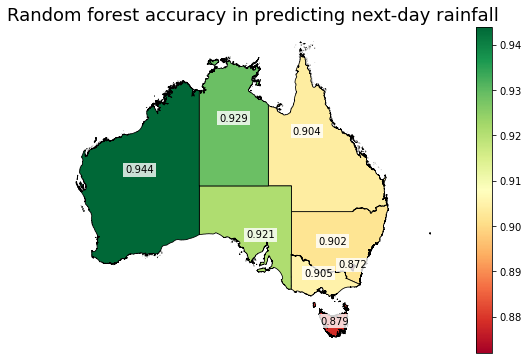

In [51]:
# set up the map figure
fig, ax = plt.subplots(1, figsize=(10, 6));

# set the title
ax.set_title("Random forest accuracy in predicting next-day rainfall", fontdict={"fontsize": "18", 
                                                                              "fontweight": "3"})

# plot the accuracy column
Australia.plot(column="Tomorrow Accuracy", linewidth=0.8, ax=ax, edgecolor='0', cmap='RdYlGn');

# annotate the states with their scores
for idx, row in Australia.iterrows():
    ax.text(row.coords[0], row.coords[1], 
            s=row["Tomorrow Accuracy"], 
            horizontalalignment='center', 
            bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

# set up the color bar
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=min(tomorrow_accuracy_list), 
                                                             vmax=max(tomorrow_accuracy_list)))

# make an empty array for the data range
sm._A = []

# plot the bar
bar = fig.colorbar(sm)

# remove axes from map
ax.axis('off')

plt.savefig(source_directory + "/Figures/Next-day_accuracy.png", dpi=300, facecolor="white")

 ## 6.3 Predicting same-day rainfall by Australian state
 
 We can quickly modify our scaled features to predict rain today, and exclude the "rainfall measured in mm" feature ("Rainfall") to make things fair.

In [68]:
# copy the list
today_feature_list = tomorrow_feature_list

# remove the target from the features
if "RainToday" in today_feature_list:
    today_feature_list.remove("RainToday")
    
# remove an obvious proxy too
if "Rainfall" in today_feature_list:
    today_feature_list.remove("Rainfall")
    
# set the new target
today_target_list = ["RainToday"]

Now let's repeat the same process as above.

In [83]:
# make a simple dictionary to store results
today_accuracy_list = []

# loop through each state and apply the same functions as above
for state in territory_dict:
    
    print(state)
    
    # mask stations not in that state
    state_df = source_df[source_df["Location"].isin(territory_dict[state])]
    
    # split into features and targets
    state_features = state_df.loc[:, today_feature_list].values
    state_target = state_df.loc[:, today_target_list].values
    
    # standardize the features by state
    state_features = StandardScaler().fit_transform(state_features)
    
    # balance the state samples
    state_features_res, state_target_res = oversample.fit_resample(state_features, state_target)
    
    # train/test split by state
    state_feature_train, state_feature_test, state_target_train, state_target_test = train_test_split(state_features_res, 
                                                                                                      state_target_res, 
                                                                                                      test_size=0.2, 
                                                                                                      random_state=42)
    
    # tune the classifier
    rf_parameters = rain_grid_search(RandomForestClassifier(), 
                                     parameter_grid, 
                                     state_feature_train, 
                                     state_target_train)
    
    # apply the classifier
    results = apply_random_forest(state_feature_train, 
                                  state_target_train, 
                                  state_feature_test, 
                                  state_target_test,
                                  rf_parameters)
    
    # add the accuracy to the list and print
    today_accuracy_list.append(round(results.accuracy,3))
    print("Accuracy: {}\n".format(round(results.accuracy, 3)))

New South Wales
Grid search time: 81.192
Time to apply the classifier: 7.793s.

Victoria
Grid search time: 70.849
Time to apply the classifier: 7.01s.

Queensland
Grid search time: 38.163
Time to apply the classifier: 3.576s.

South Australia
Grid search time: 31.702
Time to apply the classifier: 1.178s.

Western Australia
Grid search time: 30.705
Time to apply the classifier: 2.616s.

Tasmania
Grid search time: 11.807
Time to apply the classifier: 0.965s.

Northern Territories
Grid search time: 25.789
Time to apply the classifier: 1.119s.

Australian Capital Territory
Grid search time: 8.352
Time to apply the classifier: 0.589s.



Now we can add the same-day rainfalls to the same geodataframe and plot the results.

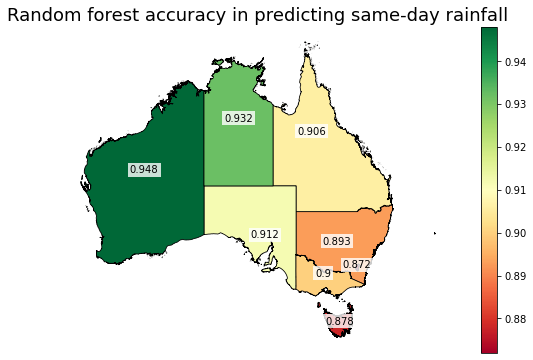

In [84]:
# add the today accuracy data as a new column
Australia["Today Accuracy"] = today_accuracy_list

# set up the today map figure
fig, ax = plt.subplots(1, figsize=(10, 6));

# set the title
ax.set_title("Random forest accuracy in predicting same-day rainfall", fontdict={"fontsize": "18", 
                                                                     "fontweight": "3"})

# plot the accuracy column
Australia.plot(column="Today Accuracy", linewidth=0.8, ax=ax, edgecolor='0', cmap='RdYlGn');

# loop through the geodataframe
for idx, row in Australia.iterrows():
    
    # annotate the states with their scores
    ax.text(row.coords[0], row.coords[1], 
            s=row["Today Accuracy"], 
            horizontalalignment='center', 
            bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

# set up the color bar
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=min(today_accuracy_list), 
                                                             vmax=max(today_accuracy_list)))

# make an empty array for the data range
sm._A = []

# plot the bar
bar = fig.colorbar(sm)

# remove axes from map
ax.axis('off')

plt.savefig(source_directory + "/Figures/Same-day_accuracy.png", dpi=300, facecolor="white")

Now we can compare the same-day and next-day results.

AttributeError: module 'matplotlib.pyplot' has no attribute 'set'

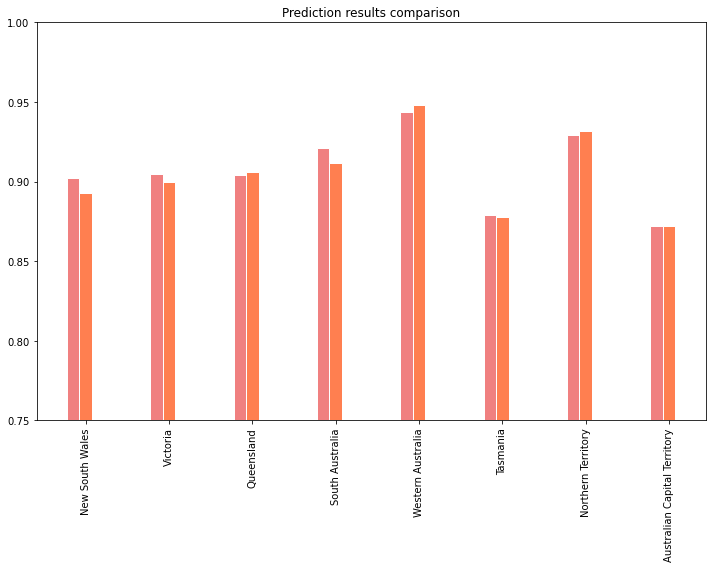

In [87]:
# set general figure parameters
fig = plt.figure(figsize=(10, 8), tight_layout=True)

# set the title
plt.title("Prediction results comparison")

# set the width of each bar
barWidth = 0.15

# set the x-axis labels
states = list(Australia["STE_NAME16"])

# get the heights of all the bars from the dictionary results, add the proccesing time          
today_bar = Australia["Tomorrow Accuracy"]
tomorrow_bar = Australia["Today Accuracy"]

# set position of each bar on the X axis
bar_x1 = np.arange(len(today_bar))
bar_x2 = [x + barWidth for x in bar_x1]

# plot each bar
plt.bar(bar_x1, today_bar, color='lightcoral', width=barWidth, edgecolor='white', label='Same-day accuracy')
plt.bar(bar_x2, tomorrow_bar, color='coral', width=barWidth, edgecolor='white', label='Next-day accuracy')

# # set the x-axis spacing and labels
plt.ylim(0.75, 1.00)
plt.xticks([r + barWidth for r in range(len(today_bar))], states)
plt.xticks(rotation=90)

# show the legend and figure, save
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig(source_directory + "/Figures/Compare_accuracy.png", dpi=300, facecolor="white")